# Variational Autoencoder

## Necessary imports

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load the Dataset

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train.csv')

In [0]:
data = df.values

## Pre-processing 

Standardize

In [0]:
X = data[:, 1:] / 255.0
y = data[:, 0]

Shuffle

In [0]:
X_train, y_train = shuffle(X, y)

Required dimensions

In [0]:
D = X_train.shape[1]
M = [200, 100]

Convert X_train to binary variable

In [0]:
X_train = (X_train>0.5).astype(np.float32)

## Building the Variational Autoencoder

**Dense Class:** Create dense layers of given size as needed, dynamically

In [0]:
class Dense(object):
  def __init__(self, X1, X2, function=tf.nn.relu):
    self.X1 = X1
    self.X2 = X2

    self.W = tf.Variable(tf.random_normal(shape=(self.X1, self.X2)) * 2 / np.sqrt(X1))
    self.b = tf.Variable(tf.zeros(X2))
    self.out = function

  def forward(self, X):
    return self.out(tf.matmul(X, self.W) + self.b)  

**variationalAutoencoder Class:** Our Varitional Autoencoder model

In [0]:
class variationalAutoencoder:
  def __init__(self, D, hidden_size):
    # list to store training loss at each step
    self.losses = []

    # batch of trianing data
    self.X = tf.placeholder(tf.float32, shape=(None, D))

    # encoder
    # NN layers of the encoder
    self.encoder_layers = []

    # input to encoder
    enc_in = D

    # create encoder layers for the input
    for enc_out in hidden_size[:-1]:
      layer = Dense(enc_in, enc_out)
      self.encoder_layers.append(layer)
      enc_in = enc_out

    # final encoder size
    M = hidden_size[-1]

    # final output layer
    new_layer = Dense(enc_in, 2*M, function=lambda x: x)
    self.encoder_layers.append(new_layer)

    # forward through layers and apply softplus activation finally
    layer_val = self.X
    for layer in self.encoder_layers:
      layer_val = layer.forward(layer_val)

    # mean  
    self.mu = layer_val[:, :M]
    # standard deviation (softplus to avoid negative values generated by NN)
    self.sigma = tf.nn.softplus(layer_val[:, M:]) + 1e-6

    # get a sample of z
    std_normal = tf.contrib.distributions.Normal(loc= tf.zeros(M), scale=tf.ones(M))
    e = std_normal.sample(tf.shape(self.mu)[0])

    self.z = e * self.sigma + self.mu

    # decoder
    # NN layers of the decoder
    self.decoder_layers = []

    # input M to decoder
    dec_in = M
    for dec_out in reversed(hidden_size[:-1]):
      layers = Dense(dec_in, dec_out)
      self.decoder_layers.append(layers)
      dec_in = dec_out

    # final decoder layer
    new_layer = Dense(dec_in, D, function=lambda x: x)
    self.decoder_layers.append(new_layer)

    # posterior predictive
    layer_val = self.z
    for layer in self.decoder_layers:
      layer_val = layer.forward(layer_val)
    logits = layer_val
    post_pred_logits = logits

    # create a bernoulli distirbution
    self.X_hat_distrib = tf.contrib.distributions.Bernoulli(logits=logits) 

    self.post_pred = self.X_hat_distrib.sample()
    self.post_pred_prob = tf.nn.sigmoid(logits)

    # get a sample of z
    std_normal = tf.contrib.distributions.Normal(loc= tf.zeros(M), scale=tf.ones(M))

    z_sigma = std_normal.sample(1)

    # prior predictive
    layer_val = z_sigma
    for layer in self.decoder_layers:
      layer_val = layer.forward(layer_val)
    logits = layer_val

    prior_pred_distrib = tf.contrib.distributions.Bernoulli(logits=logits)
    self.prior_pred = prior_pred_distrib.sample()
    self.prior_pred_prob = tf.nn.sigmoid(logits)

    # prior predicitive with input
    self.z_in = tf.placeholder(tf.float32, shape=(None, M))
    layer_val = self.z_in
    for layer in self.decoder_layers:
      layer_val = layer.forward(layer_val)
    logits = layer_val
    self.prior_pred_in_prob = tf.nn.sigmoid(logits)  

    # loss function ELBO
    # KL Divergence
    kl = -tf.log(self.sigma) + 0.5 * (self.sigma**2 + self.mu**2) - 0.5
    kl = tf.reduce_sum(kl, axis=1)

    # Expected log likelihood
    expected = tf.reduce_sum(self.X_hat_distrib.log_prob(self.X), axis=1)

    # loss operation, reduce ELBO loss 
    self.loss_operation = tf.reduce_sum(expected - kl)

    # train operation, minimze ELBO
    self.train_operation = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(-self.loss_operation)

    # session and variables initialization
    self.init_operation = tf.global_variables_initializer()
    self.sess = tf.Session()
    self.sess.run(self.init_operation)

    # model saver object
    self.saver = tf.train.Saver()

  def fit(self, X, epochs=30, batch_size=64):
    # number of batches (or) step size
    num_batches = len(X) // batch_size
    print('Training...')

    for e in range(epochs):
      print("Epoch {}".format(e+1))
      # shuffle training data at each epoch
      np.random.shuffle(X)

      # create new batch at each step and train 
      for offset in range(num_batches):
        new_batch = X[offset*batch_size:(offset+1)*batch_size]
        a, l = self.sess.run((self.train_operation, self.loss_operation), feed_dict={self.X: new_batch})
        l /= batch_size
        self.losses.append(l)
      print("Loss: %.2f" % self.losses[e])  

  def transform(self, X):
    # transform function
    return self.sess.run(self.mu, feed_dict={self.X: X})

  def prior_predict(self, z):
    # prior predictive with input function
    return self.sess.run(self.prior_pred_in_prob, feed_dict={self.z_in: z})

  def post_predict(self, X):
    # posterior predictive with input function
    return self.sess.run(self.post_pred, feed_dict={self.X: X})

  def prior_sample_prob(self):
    # prior predictive function
    return self.sess.run((self.prior_pred, self.prior_pred_prob))

  def save_weights(self, path):
    # save the model's parameters/weights
    self.saver.save(self.sess, path)
    print("Saved successfully")

## Train the Variational Autoencoder

Instantiate the Variational Autoencoder model

In [0]:
model = variationalAutoencoder(D, M)

Train the model

In [12]:
model.fit(X_train)

Training...
Epoch 1
Loss: -1358.36
Epoch 2
Loss: -908.41
Epoch 3
Loss: -780.13
Epoch 4
Loss: -712.02
Epoch 5
Loss: -676.45
Epoch 6
Loss: -636.95
Epoch 7
Loss: -612.93
Epoch 8
Loss: -578.22
Epoch 9
Loss: -561.39
Epoch 10
Loss: -541.05
Epoch 11
Loss: -531.33
Epoch 12
Loss: -509.39
Epoch 13
Loss: -498.50
Epoch 14
Loss: -488.73
Epoch 15
Loss: -473.40
Epoch 16
Loss: -453.06
Epoch 17
Loss: -437.23
Epoch 18
Loss: -434.84
Epoch 19
Loss: -411.33
Epoch 20
Loss: -392.14
Epoch 21
Loss: -405.40
Epoch 22
Loss: -375.63
Epoch 23
Loss: -365.99
Epoch 24
Loss: -360.73
Epoch 25
Loss: -364.14
Epoch 26
Loss: -376.22
Epoch 27
Loss: -345.22
Epoch 28
Loss: -352.45
Epoch 29
Loss: -349.11
Epoch 30
Loss: -339.04


## Evaluation

Plot the Variational Autoencoder loss

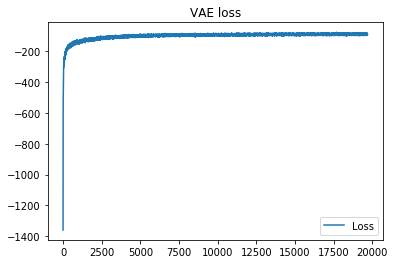

In [13]:
plt.plot(model.losses, label='Loss')
plt.title('VAE loss')
plt.legend()

Visualize original and variational autoencoder generated image

Text(0.5, 1.0, 'Generated')

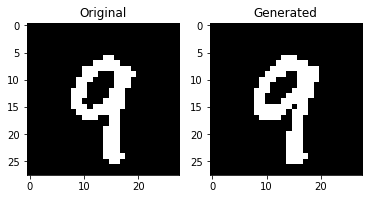

In [14]:
i = np.random.choice(len(X_train))
x = X_train[i]

img = model.post_predict([x]).reshape(28, 28)

plt.subplot(1,2,1)
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(img, cmap='gray')
plt.title("Generated")

Visualize variational autoencoder prior predicitive image from model's distribution

Text(0.5, 1.0, 'Prior Predictive Generated')

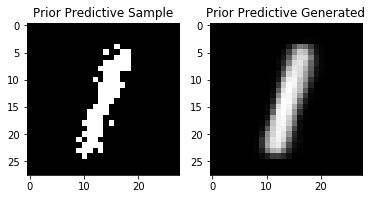

In [30]:
img, prob = model.prior_sample_prob()

img = img.reshape(28, 28)
probs = prob.reshape(28, 28)

plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title("Prior Predictive Sample")

plt.subplot(1,2,2)
plt.imshow(probs, cmap='gray')
plt.title("Prior Predictive Generated")

## Save the model

In [16]:
model.save_weights('/content/drive/My Drive/Colab Notebooks/models/variational_autoencoder/')

Saved successfully


## Visualizing the Latent Space

In [0]:
model = variationalAutoencoder(D, [200, 100, 2])

In [18]:
model.fit(X_train)

Training...
Epoch 1
Loss: -2947.88
Epoch 2
Loss: -3086.58
Epoch 3
Loss: -1009.95
Epoch 4
Loss: -941.62
Epoch 5
Loss: -821.91
Epoch 6
Loss: -697.46
Epoch 7
Loss: -696.84
Epoch 8
Loss: -615.36
Epoch 9
Loss: -615.50
Epoch 10
Loss: -626.62
Epoch 11
Loss: -572.93
Epoch 12
Loss: -562.07
Epoch 13
Loss: -538.86
Epoch 14
Loss: -510.48
Epoch 15
Loss: -489.83
Epoch 16
Loss: -473.85
Epoch 17
Loss: -438.56
Epoch 18
Loss: -433.12
Epoch 19
Loss: -391.33
Epoch 20
Loss: -383.96
Epoch 21
Loss: -368.03
Epoch 22
Loss: -348.95
Epoch 23
Loss: -312.96
Epoch 24
Loss: -309.35
Epoch 25
Loss: -284.52
Epoch 26
Loss: -275.46
Epoch 27
Loss: -265.38
Epoch 28
Loss: -262.64
Epoch 29
Loss: -250.17
Epoch 30
Loss: -252.24


In [0]:
n = 20

In [0]:
x_val = np.linspace(-3, 3, n)
y_val = np.linspace(-3, 3, n)
img = np.empty((28*n, 28*n))

In [0]:
Z = []

for i, x in enumerate(x_val):
  for j, y in enumerate(y_val):
    z = [x, y]
    Z.append(z)

In [0]:
X_k = model.prior_predict(Z)

In [0]:
k = 0

for i, x in enumerate(x_val):
  for j, y in enumerate(y_val):
    x_visu = X_k[k]
    k+=1
    x_visu = x_visu.reshape(28, 28)
    img[(n-i-1)*28:(n-i)*28, j*28:(j+1)*28] = x_visu

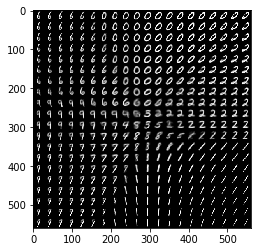

In [29]:
plt.imshow(img, cmap='gray')